# 5 — Advanced Volatility and Hedging (Simulation)

In this notebook we move beyond static pricing and payoff diagrams and simulate
**dynamic trading strategies**:

1. Simulate stock price paths with geometric Brownian motion (GBM).
2. Implement a **delta-hedging engine** for a single option.
3. Build a **gamma scalping** strategy using a long straddle and frequent rebalancing.
4. Compare **realized volatility** vs **implied volatility** on simulated paths.
5. Demonstrate **volatility arbitrage**:
   - when implied volatility is higher than realized volatility,
   - and when implied volatility is lower than realized volatility.

All simulations use discrete-time approximations, but the logic matches the
continuous-time Black–Scholes framework.


In [1]:
import sys
from pathlib import Path

# Adjust this path if needed
project_root = Path(r"C:\Users\Ruben\Desktop\Projects\OptionPricing")
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

from option_pricing.black_scholes import black_scholes_call, black_scholes_put
from option_pricing.greeks import delta_call, delta_put
from option_pricing.utils import annualize_days

import numpy as np
import math
import matplotlib.pyplot as plt

print("Project root:", project_root)


Project root: C:\Users\Ruben\Desktop\Projects\OptionPricing


## 1. Geometric Brownian Motion (GBM) simulator

Under the Black–Scholes assumptions, the stock price follows a GBM:

$$
dS_t = \mu S_t \, dt + \sigma_{\text{real}} S_t \, dW_t,
$$

with solution:

$$
S_T = S_0 \exp\left\{\left(\mu - \frac{1}{2}\sigma_{\text{real}}^2\right)T
+ \sigma_{\text{real}} \sqrt{T} Z\right\},
$$

where $Z \sim N(0,1)$.

In discrete time with $N$ steps of size $\Delta t = T/N$, we approximate:

$$
S_{t + \Delta t} = S_t \exp\left\{\left(\mu - \frac{1}{2}\sigma_{\text{real}}^2\right)\Delta t
+ \sigma_{\text{real}}\sqrt{\Delta t}\, \epsilon_t\right\},
$$

with $\epsilon_t \sim N(0,1)$ independent.


In [2]:
def simulate_gbm_path(S0, mu, sigma_real, T, n_steps, rng=None):
    """
    Simulate one GBM price path.

    Parameters
    ----------
    S0 : float
        Initial price.
    mu : float
        Drift of the process.
    sigma_real : float
        Realized (true) volatility of the process.
    T : float
        Time horizon in years.
    n_steps : int
        Number of time steps.
    rng : np.random.Generator or None
        Random number generator.

    Returns
    -------
    np.ndarray
        Array of shape (n_steps + 1,) with simulated prices.
    """
    if rng is None:
        rng = np.random.default_rng()

    dt = T / n_steps
    prices = np.empty(n_steps + 1)
    prices[0] = S0

    for t in range(n_steps):
        z = rng.standard_normal()
        prices[t + 1] = prices[t] * math.exp(
            (mu - 0.5 * sigma_real ** 2) * dt + sigma_real * math.sqrt(dt) * z
        )

    return prices


In [3]:
def realized_vol_from_path(S_path, trading_days=252):
    """
    Estimate realized volatility from a price path.

    Parameters
    ----------
    S_path : array-like
        Sequence of prices S_0, S_1, ..., S_N.
    trading_days : int
        Number of trading days per year for annualization.

    Returns
    -------
    float
        Annualized realized volatility.
    """
    S_path = np.asarray(S_path)
    log_returns = np.diff(np.log(S_path))
    if len(log_returns) == 0:
        return float("nan")
    daily_vol = np.std(log_returns, ddof=1)
    return daily_vol * math.sqrt(trading_days)


## 2. Delta hedging engine (long or short straddle)

We consider a position in an at-the-money **straddle**:

- one call and one put with the same strike $K$ and maturity $T$,
- priced with an **implied volatility** $\sigma_{\text{imp}}$.

We assume:

- the *true* (realized) stock volatility is $\sigma_{\text{real}}$,
- we hedge the position in the stock to keep the total delta close to zero.

For a straddle:

- price:
  $$
  V = C + P,
  $$
- delta:
  $$
  \Delta_{\text{straddle}} = \Delta_{\text{call}} + \Delta_{\text{put}}.
  $$

We will simulate:

- **long straddle**: long gamma, short theta (gamma scalping),
- **short straddle**: short gamma, long theta (volatility selling).

We track the P&L of a **self-financing** delta-hedged portfolio.
Initial portfolio value is set to zero.


In [4]:
def delta_hedge_straddle_path(
    S_path,
    K,
    T,
    r,
    sigma_imp,
    side=+1,
):
    """
    Simulate delta hedging of a straddle along one price path.

    Parameters
    ----------
    S_path : np.ndarray
        Array of prices S_0, ..., S_N.
    K : float
        Strike of call and put.
    T : float
        Time to maturity (years).
    r : float
        Risk-free rate (continuously compounded).
    sigma_imp : float
        Implied volatility used for pricing and deltas.
    side : int
        +1 for long straddle, -1 for short straddle.

    Returns
    -------
    dict with:
        'PnL' : float
            Final P&L of the hedged position.
        'PnL_path' : np.ndarray
            P&L along the path (portfolio value through time).
        'deltas' : np.ndarray
            Straddle deltas at each time step.
    """
    S_path = np.asarray(S_path)
    N = len(S_path) - 1
    dt = T / N

    # Arrays
    deltas = np.empty(N + 1)
    portfolio_values = np.empty(N + 1)

    # Initial time
    t = 0.0
    S0 = S_path[0]
    C0 = black_scholes_call(S0, K, T, r, sigma_imp)
    P0 = black_scholes_put(S0, K, T, r, sigma_imp)
    V0 = C0 + P0

    delta0 = delta_call(S0, K, T, r, sigma_imp) + delta_put(S0, K, T, r, sigma_imp)
    deltas[0] = delta0

    # side * V0 is the value of our options position (long or short)
    # We choose cash0 so that initial total portfolio value is 0:
    # value0 = side*V0 + n_shares * S0 + cash0 = 0
    n_shares = -side * delta0
    cash = -(side * V0 + n_shares * S0)
    portfolio_values[0] = 0.0

    for i in range(N):
        S_t = S_path[i]
        S_next = S_path[i + 1]

        # Grow cash at risk-free rate
        cash *= math.exp(r * dt)

        # Move to t+dt
        t_next = (i + 1) * dt
        T_remaining = max(T - t_next, 1e-8)

        # Recompute option value and delta at t+dt
        C_next = black_scholes_call(S_next, K, T_remaining, r, sigma_imp)
        P_next = black_scholes_put(S_next, K, T_remaining, r, sigma_imp)
        V_next = C_next + P_next

        delta_next = delta_call(S_next, K, T_remaining, r, sigma_imp) + \
                     delta_put(S_next, K, T_remaining, r, sigma_imp)

        # Desired number of shares to be delta-neutral:
        desired_shares = -side * delta_next
        d_shares = desired_shares - n_shares

        # Trade d_shares at S_next
        cash -= d_shares * S_next
        n_shares = desired_shares

        # Store
        deltas[i + 1] = delta_next
        portfolio_values[i + 1] = side * V_next + n_shares * S_next + cash

    # At maturity: options are replaced by payoff
    S_T = S_path[-1]
    payoff_straddle = abs(S_T - K)
    option_value_T = side * payoff_straddle

    # Close stock position
    cash += n_shares * S_T
    n_shares = 0

    # Final portfolio value
    final_value = option_value_T + cash

    # Replace last portfolio value with final value
    portfolio_values[-1] = final_value

    return {
        "PnL": final_value,
        "PnL_path": portfolio_values,
        "deltas": deltas,
    }


In [5]:
S0 = 100.0
K = 100.0
T = 1.0          # 1 year
r = 0.01
sigma_imp = 0.20 # implied volatility used for pricing
sigma_real = 0.20  # we will vary this later
n_steps = 252    # daily steps

rng = np.random.default_rng(42)

print("Base setup:")
print(f"S0 = {S0}, K = {K}, T = {T}, r = {r}")
print(f"sigma_imp = {sigma_imp}, sigma_real = {sigma_real}")
print(f"n_steps = {n_steps}")


Base setup:
S0 = 100.0, K = 100.0, T = 1.0, r = 0.01
sigma_imp = 0.2, sigma_real = 0.2
n_steps = 252


## 3. Gamma scalping example

We start with a **long straddle** (side = +1) and hedge delta at every step.

Intuition:

- If **realized volatility** is higher than **implied volatility**:
  - the market underpriced volatility,
  - long gamma (via the straddle) should make money on average.

We first simulate a scenario with

$$
\sigma_{\text{real}} > \sigma_{\text{imp}}.
$$


In [6]:
sigma_real_high = 0.35   # true volatility > implied

S_path_high = simulate_gbm_path(S0, mu=r, sigma_real=sigma_real_high,
                                T=T, n_steps=n_steps, rng=rng)

realized_high = realized_vol_from_path(S_path_high)

result_high = delta_hedge_straddle_path(
    S_path=S_path_high,
    K=K,
    T=T,
    r=r,
    sigma_imp=sigma_imp,
    side=+1,   # long straddle (long gamma)
)

print(f"Realized vol (high scenario): {realized_high:.4f}")
print(f"Implied vol:                  {sigma_imp:.4f}")
print(f"Final P&L (long straddle, high vol): {result_high['PnL']:.4f}")


Realized vol (high scenario): 0.3282
Implied vol:                  0.2000
Final P&L (long straddle, high vol): 5.9960


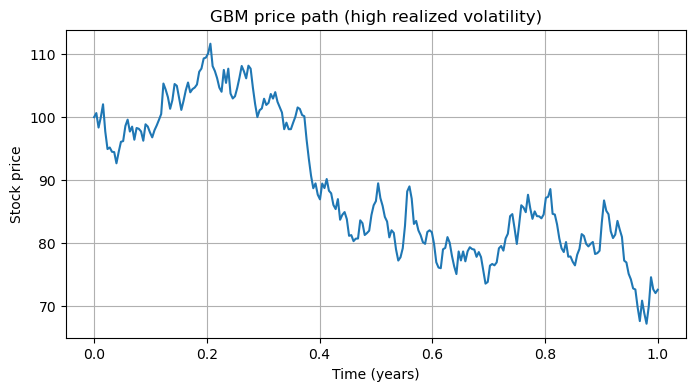

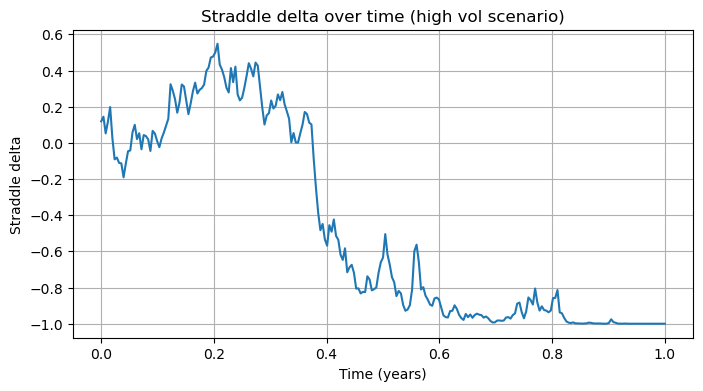

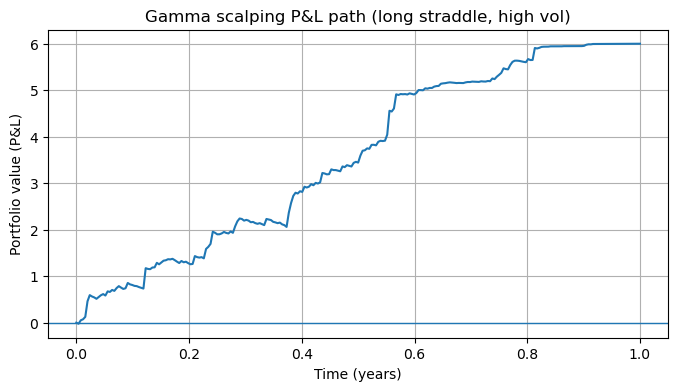

In [7]:
time_grid = np.linspace(0, T, n_steps + 1)

plt.figure(figsize=(8, 4))
plt.plot(time_grid, S_path_high)
plt.xlabel("Time (years)")
plt.ylabel("Stock price")
plt.title("GBM price path (high realized volatility)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time_grid, result_high["deltas"])
plt.xlabel("Time (years)")
plt.ylabel("Straddle delta")
plt.title("Straddle delta over time (high vol scenario)")
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 4))
plt.plot(time_grid, result_high["PnL_path"])
plt.axhline(0, linewidth=1)
plt.xlabel("Time (years)")
plt.ylabel("Portfolio value (P&L)")
plt.title("Gamma scalping P&L path (long straddle, high vol)")
plt.grid(True)
plt.show()


In [8]:
sigma_real_low = 0.10  # true volatility < implied

S_path_low = simulate_gbm_path(S0, mu=r, sigma_real=sigma_real_low,
                               T=T, n_steps=n_steps, rng=rng)

realized_low = realized_vol_from_path(S_path_low)

result_low = delta_hedge_straddle_path(
    S_path=S_path_low,
    K=K,
    T=T,
    r=r,
    sigma_imp=sigma_imp,
    side=+1,   # long straddle again
)

print(f"Realized vol (low scenario): {realized_low:.4f}")
print(f"Implied vol:                 {sigma_imp:.4f}")
print(f"Final P&L (long straddle, low vol): {result_low['PnL']:.4f}")


Realized vol (low scenario): 0.0986
Implied vol:                 0.2000
Final P&L (long straddle, low vol): -8.5901


## 4. Realized vs implied volatility (single-path comparison)

From the two examples we see:

- In the **high-vol scenario**: realized $> \sigma_{\text{imp}}$,
  long gamma scalping produced **positive** P&L.

- In the **low-vol scenario**: realized $< \sigma_{\text{imp}}$,
  long gamma scalping produced **negative** P&L.

This matches the intuition that:

> Long gamma (long options) benefits when realized volatility exceeds the volatility
> implied by the option price.


## 5. Delta hedging P&L for a single call

To isolate delta hedging, we now look at a **single call option**, not a straddle.

We simulate:

- long one call,
- dynamically delta-hedge it,
- and observe the hedging P&L.

If the true volatility equals the implied volatility, the hedged position should
have P&L close to zero on average (in a risk-neutral world).


In [9]:
def delta_hedge_call_path(S_path, K, T, r, sigma_imp, side=+1):
    """
    Delta-hedge a call option along one path.

    side = +1 for long call, -1 for short call.
    """
    S_path = np.asarray(S_path)
    N = len(S_path) - 1
    dt = T / N

    deltas = np.empty(N + 1)
    portfolio_values = np.empty(N + 1)

    t = 0.0
    S0 = S_path[0]
    C0 = black_scholes_call(S0, K, T, r, sigma_imp)
    delta0 = delta_call(S0, K, T, r, sigma_imp)

    # side * C0 is option value position
    n_shares = -side * delta0
    cash = -(side * C0 + n_shares * S0)
    portfolio_values[0] = 0.0
    deltas[0] = delta0

    for i in range(N):
        S_t = S_path[i]
        S_next = S_path[i + 1]

        cash *= math.exp(r * dt)

        t_next = (i + 1) * dt
        T_remaining = max(T - t_next, 1e-8)

        C_next = black_scholes_call(S_next, K, T_remaining, r, sigma_imp)
        delta_next = delta_call(S_next, K, T_remaining, r, sigma_imp)

        desired_shares = -side * delta_next
        d_shares = desired_shares - n_shares

        cash -= d_shares * S_next
        n_shares = desired_shares

        deltas[i + 1] = delta_next
        portfolio_values[i + 1] = side * C_next + n_shares * S_next + cash

    # At maturity: call payoff
    S_T = S_path[-1]
    payoff_call = max(S_T - K, 0.0)
    option_value_T = side * payoff_call

    cash += n_shares * S_T
    n_shares = 0

    final_value = option_value_T + cash
    portfolio_values[-1] = final_value

    return {"PnL": final_value, "PnL_path": portfolio_values, "deltas": deltas}


In [10]:
sigma_real_equal = sigma_imp

S_path_equal = simulate_gbm_path(S0, mu=r, sigma_real=sigma_real_equal,
                                 T=T, n_steps=n_steps, rng=rng)

realized_equal = realized_vol_from_path(S_path_equal)

call_result = delta_hedge_call_path(
    S_path=S_path_equal,
    K=K,
    T=T,
    r=r,
    sigma_imp=sigma_imp,
    side=+1,  # long call
)

print(f"Realized vol (call example): {realized_equal:.4f}")
print(f"Implied vol:                 {sigma_imp:.4f}")
print(f"Final P&L (delta-hedged long call): {call_result['PnL']:.4f}")


Realized vol (call example): 0.2074
Implied vol:                 0.2000
Final P&L (delta-hedged long call): 0.1515


## 6. Volatility arbitrage demonstration (many paths)

We now show how **selling volatility** can be profitable if the market consistently
overprices volatility.

Setup:

- True volatility: $\sigma_{\text{real}}$.
- Implied volatility used for pricing: $\sigma_{\text{imp}}$.
- We **short** an at-the-money straddle and delta-hedge it.
- We repeat this over many simulated paths and look at the distribution of P&L.

We compare two cases:

1. $\sigma_{\text{imp}} > \sigma_{\text{real}}$ — options are overpriced (short vol should profit).
2. $\sigma_{\text{imp}} < \sigma_{\text{real}}$ — options are underpriced (short vol should lose).


In [11]:
def vol_arb_experiment(
    n_paths,
    S0,
    K,
    T,
    r,
    sigma_real,
    sigma_imp,
    n_steps,
    side=-1,
    seed=123,
):
    """
    Run many-path simulation of a delta-hedged straddle.

    Returns array of final P&Ls.
    """
    rng = np.random.default_rng(seed)
    pnls = np.empty(n_paths)

    for i in range(n_paths):
        S_path = simulate_gbm_path(S0, mu=r, sigma_real=sigma_real,
                                   T=T, n_steps=n_steps, rng=rng)
        result = delta_hedge_straddle_path(
            S_path=S_path,
            K=K,
            T=T,
            r=r,
            sigma_imp=sigma_imp,
            side=side,
        )
        pnls[i] = result["PnL"]

    return pnls


In [12]:
n_paths = 300

sigma_real_case1 = 0.20
sigma_imp_case1 = 0.30  # market overprices volatility

pnls_case1 = vol_arb_experiment(
    n_paths=n_paths,
    S0=S0,
    K=K,
    T=T,
    r=r,
    sigma_real=sigma_real_case1,
    sigma_imp=sigma_imp_case1,
    n_steps=n_steps,
    side=-1,   # short straddle (short vol)
    seed=1,
)

print("Case 1: implied vol > realized vol")
print(f"sigma_real  = {sigma_real_case1:.2f}")
print(f"sigma_imp   = {sigma_imp_case1:.2f}")
print(f"Mean P&L    = {pnls_case1.mean():.4f}")
print(f"Std of P&L  = {pnls_case1.std(ddof=1):.4f}")


Case 1: implied vol > realized vol
sigma_real  = 0.20
sigma_imp   = 0.30
Mean P&L    = 8.0743
Std of P&L  = 2.4808


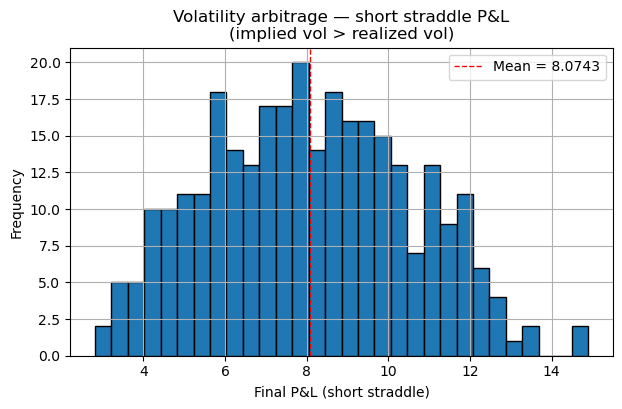

In [13]:
plt.figure(figsize=(7, 4))
plt.hist(pnls_case1, bins=30, edgecolor="black")
plt.axvline(pnls_case1.mean(), color="red", linestyle="--", linewidth=1,
            label=f"Mean = {pnls_case1.mean():.4f}")
plt.xlabel("Final P&L (short straddle)")
plt.ylabel("Frequency")
plt.title("Volatility arbitrage — short straddle P&L\n(implied vol > realized vol)")
plt.legend()
plt.grid(True)
plt.show()


In [14]:
sigma_real_case2 = 0.30
sigma_imp_case2 = 0.20  # market underprices volatility

pnls_case2 = vol_arb_experiment(
    n_paths=n_paths,
    S0=S0,
    K=K,
    T=T,
    r=r,
    sigma_real=sigma_real_case2,
    sigma_imp=sigma_imp_case2,
    n_steps=n_steps,
    side=-1,   # still short straddle
    seed=2,
)

print("Case 2: implied vol < realized vol")
print(f"sigma_real  = {sigma_real_case2:.2f}")
print(f"sigma_imp   = {sigma_imp_case2:.2f}")
print(f"Mean P&L    = {pnls_case2.mean():.4f}")
print(f"Std of P&L  = {pnls_case2.std(ddof=1):.4f}")


Case 2: implied vol < realized vol
sigma_real  = 0.30
sigma_imp   = 0.20
Mean P&L    = -7.8232
Std of P&L  = 3.8497


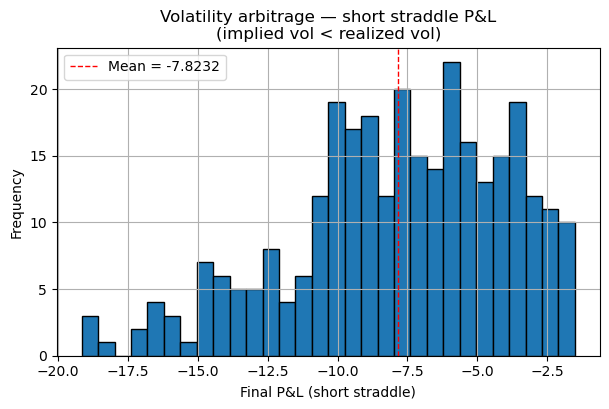

In [15]:
plt.figure(figsize=(7, 4))
plt.hist(pnls_case2, bins=30, edgecolor="black")
plt.axvline(pnls_case2.mean(), color="red", linestyle="--", linewidth=1,
            label=f"Mean = {pnls_case2.mean():.4f}")
plt.xlabel("Final P&L (short straddle)")
plt.ylabel("Frequency")
plt.title("Volatility arbitrage — short straddle P&L\n(implied vol < realized vol)")
plt.legend()
plt.grid(True)
plt.show()


# Conclusion

In this advanced notebook we:

- Simulated GBM price paths with a specified **realized** volatility.
- Implemented a **delta-hedging engine** for:
  - a straddle (long or short),
  - a single call option.
- Built a **gamma scalping** strategy (long delta-hedged straddle) and saw that:
  - when realized volatility $> \sigma_{\text{imp}}$, P&L tends to be positive,
  - when realized volatility $< \sigma_{\text{imp}}$, P&L tends to be negative.
- Computed **realized volatility** from simulated paths and compared it to
  **implied volatility** used for pricing.
- Ran many-path simulations of **short straddles** to demonstrate
  **volatility arbitrage**:
  - if implied volatility is higher than realized volatility, a delta-hedged
    short straddle tends to make money on average;
  - if implied volatility is lower than realized volatility, the same strategy
    tends to lose money.

This notebook connects:

- the static Black–Scholes formulas,
- Greeks and delta hedging,
- and the relationship between implied and realized volatility.

It shows how abstract concepts like **gamma**, **theta**, and **volatility trading**
translate into concrete P&L outcomes in a simulated market.

In the final notebook (6 — Conclusion), we will summarize the entire project,
discuss limitations of the Black–Scholes model, and outline possible extensions
(stochastic volatility, jumps, dividends, volatility surfaces, etc.).
